In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import random


# import hyperparameters
from brnn_hyperparams import *

import numpy as np

# processing bar
from tqdm import tqdm

# plots
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'{model_name}board_test')

## Logger

In [3]:
import logging
logging.root.setLevel(logging.INFO)
# logging.basicConfig(level=logging.NOTSET)
logging.basicConfig(filename=log_name+'_test', 
                    filemode='a',
                    format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %I:%M:%S %P',
                    level=logging.INFO)

In [4]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.warning('Device: ' + device.type)
device

device(type='cuda')

## Load data
### rewrite protein Dataset function  

In [5]:
def load_dataset(fpath):
    '''
    params:
        fpath - path to fasta file, training or test
                ***The format of the sets:

                The first two lines are a global header:
                total_number_of_records
                input_size number_of_classes

                total_number_of_records is simply the number of proteins in the set,
                input_size is how many numbers are used to represent one amino acid (21
                or 22, probably, in your case) and number_of_classes is the number of
                classes...

                After that you have the proteins, 5 lines each:

                line 1: name of the protein
                line 2: number of amino acids in the protein
                line 3: input
                line 4: targets
                line 5: empty

                You can use any name you want so long as it's unique, a single word, and
                not outrageously long.

                The input should be a single long list of the numbers representing the
                amino acids in the protein. If you use, say, 21 numbers per amino acid,
                and the protein is 100 amino acids long, the input line will contain
                2100 numbers, with the first 21 being the representation of the first
                amino acid in the protein, the following 21 the representation of the
                second, etc.
                For the moment (before we use alignments) the representation of an amino
                acid will be a one-hot encoding, e.g.:

                A     -> 1 0 0 0 ..... 0 0
                C     -> 0 1 0 0 ..... 0 0
                ...
                Y     -> 0 0 0 0 ..... 1 0
                other -> 0 0 0 0 ..... 0 1

                where "other" is unknown or weird amino acid (X, B, J, O, U, Z)

                The line containing the targets is a list of integers representing the
                classes of the amino acids. There are as many integers as there are
                amino acids in the protein. You can choose whatever integers you want,
                but it's probably simplest to have something like class1=0, class2=1,
                class3=2, etc..

                (notice that in the sample sets in the directory you have a more
                complicated representation of the inputs, where there are a lot of
                floating point numbers rather than just 0 and 1, and that's because
                those inputs are frequency profiles from MSA - so you can see how the
                code works for both kinds of inputs)
                
    returns:
        p_data - list[data_tensor, target_tensor]
        p_lens - list, protein length
    
    Note: 
        - the reason not using tensor to save protein Sequences and Targets is we have varying length sequences! 
        - solve this problem we could consider pading. But our dataset lens range from about 20 to 10,000. 
            Thus, padding maybe not a good idea here.
    '''
    num_protein = 0
    num_i = 0
    num_o = 0

    # p_names = []
    p_lens = []
    # p_seqs = []
    # p_anns = []
    p_data = np.empty((0, 45, 21), dtype=float)
    p_label = np.empty((0, 1), dtype=float)
    with open(fpath) as fp:
        num_protein = int(fp.readline())
        num_io = fp.readline().split(' ')
        num_i = int(num_io[0])
        num_o = int(num_io[0])

        line = fp.readline()
        while line:
            # p_name = line[:-1]
            p_len = int(fp.readline())
            print(p_len)
            p_sequence = [int(x) for x in fp.readline().split(' ')]
                                      #dtype=torch.float32)
            ## look forwar and backward 22 AAs. Padding both sides 21*22 zeros.
            seq_with_padding = []
            p_ses_pad = [0] * 21 * 22
            seq_with_padding = seq_with_padding + p_ses_pad
            seq_with_padding = seq_with_padding + p_sequence
            seq_with_padding = seq_with_padding + p_ses_pad
            
            for i in range(p_len):
                p_data = np.append(p_data, np.array(seq_with_padding[i*21: (i*21+21*45)]).reshape(-1, 45, 21), axis=0)
                
            #.reshape(-1, 21)
            p_annotation = np.array([int(x) for x in fp.readline().split(' ')], dtype=float).reshape(-1, 1)
            # skip empty
            next(fp)
            # p_names.append(p_name)
            p_lens.append(p_len)
            p_label = np.append(p_label, p_annotation, axis=0)
            line = fp.readline()
            
    p_data = torch.tensor(p_data, dtype=torch.float32)
    p_label = torch.tensor(p_label, dtype=torch.float32)
    return p_data, p_label, p_lens

class ProteinDataset(Dataset):
    
    def __init__(self, fpath, transform=None):
        self.p_data, self.p_label, self.p_lens = load_dataset(fpath)
    
    def __len__(self) -> int:
        return sum(self.p_lens)
    
    def __getitem__(self, i) -> torch.Tensor:
        return self.p_data[i], self.p_label[i]    
        

In [6]:
# !!!! 
# file need extra one empty line
# !!!!
train_ds = ProteinDataset(train_fpath)
test_ds = ProteinDataset(test_fpath)

640
103
640
103


In [7]:
# dataloader
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False)

## Plots
### ROC plot

In [8]:
def rocPlot(train_label, train_probs, val_label, val_probs):
    fig = plt.figure(figsize=(12, 6))
    fpr, tpr, thresholds = roc_curve(train_label, train_probs)

    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 1)
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=model_name+" ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Training")
    plt.legend(loc="lower right")

    fpr, tpr, thresholds = roc_curve(val_label, val_probs)

    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=model_name+" ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Validation")
    plt.legend(loc="lower right")
    plt.show()
    return fig

## Model

In [9]:
# set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                         bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        # Forward Prop
        # out, (hn, cn) = self.lstm(x,  (h0, c0))
        out, _ = self.lstm(x,  (h0, c0))
        # all training example, last hidden state, all 
        out = self.fc(out[:,-1, :])
        out = self.sigmoid(out)
        return out
    
    def train_batch(self, train_loader, optimizer, criterion):
        # set training state to model
        self.to(device)
        self.train()
        
        with tqdm(total=len(train_loader), position=0) as progress_bar:
            for batch_idx, (data, label) in enumerate(train_loader):
                data = data.to(device)
                label = label.to(device)
                optimizer.zero_grad()
                output = self(data)
                loss = criterion(output, label)
                loss.backward()
                optimizer.step()
                progress_bar.update(1)
                
    def val_batch(self, val_data, criterion): 
        # set evaluation state to the model
        self.to(device)
        self.eval()
        losses = []
        
        class_probs = []
        class_label = []
        
        # no gradient needed
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_data):
                data = data.to(device)
                target = target.to(device)
                # forward
                scores = self(data)
                loss = criterion(scores, target)
                # ERROR
                losses.append(loss.cpu()) # loss for each batch
                # save for ploting curve
                class_probs.append(scores.squeeze(-1).cpu())
                class_label.append(target.cpu())
                
        # overall loss
        loss = np.mean(losses)
        return loss, class_probs, class_label

## Initialization

In [10]:
# init model
model = BRNN(input_size, hidden_size, num_layers, num_classes)
# propogation of two classes

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


## Training & Test

100%|█████████████████████████████████████████████████████████████| 149/149 [00:04<00:00, 32.15it/s]


Training: Loss:
0.29088274
VAL: Loss:
0.2908847


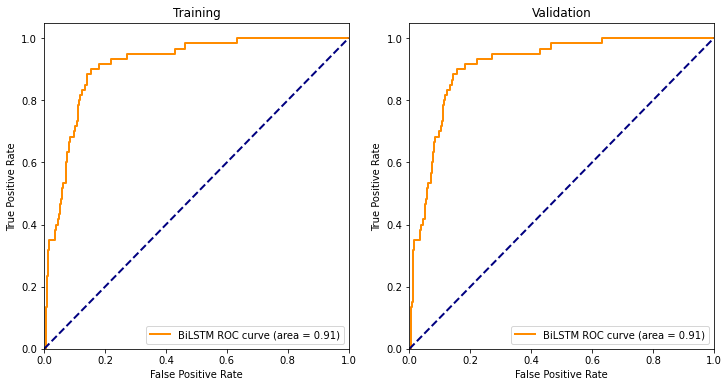

100%|█████████████████████████████████████████████████████████████| 149/149 [00:04<00:00, 33.16it/s]


Training: Loss:
0.20929945
VAL: Loss:
0.20930286


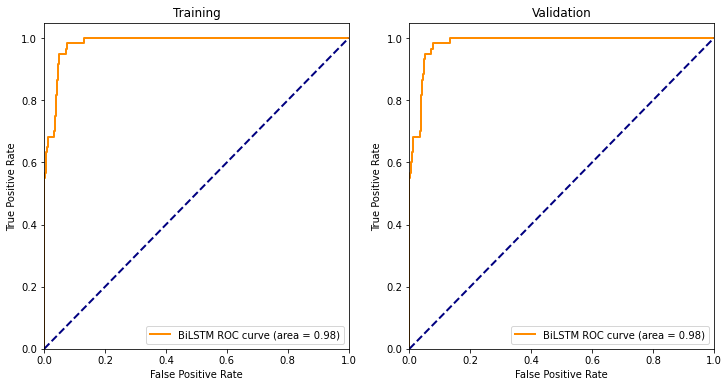

 99%|████████████████████████████████████████████████████████████▌| 148/149 [00:04<00:00, 32.48it/s]


KeyboardInterrupt: 

In [11]:
logging.warning(f"model_name: {model_name} \n \
                batch_size: {batch_size} \n \
                num_epochs: {num_epochs} \n \
                learning_rate: {learning_rate}")

for epoch in range(num_epochs):
    logging.warning('*********************************')
    logging.warning('epoch: ' + str(epoch))
    logging.warning('*********************************')
    ################
    # 3.1. Training
    ################
    logging.warning('1. TRAINING:')
    # plot pr and roc curve or not
    plot_pr_roc = (epoch % plot_nEpoch == 0)

    # training
    model.train_batch(train_dl, optimizer, criterion)
    
    # acc & loss
    train_loss, t_class_probs, t_class_label = model.val_batch(train_dl, criterion)
    val_loss, v_class_probs, v_class_label = model.val_batch(test_dl, criterion)
    
    # val_accs.append(val_acc)
    
    print('Training: Loss:')
    print(train_loss)
    
    print('VAL: Loss:')
    print(val_loss)
    
    logging.warning('Training:')
    logging.warning(f'Loss: {train_loss}')

    logging.warning('Validation:')
    logging.warning(f'Loss: {val_loss}')
    
    ##
    # for tensorboard plots
    ##
    writer.add_scalar("TRAIN: loss", train_loss, epoch)
    #writer.add_scalar("TRAIN: acc", train_acc, epoch)
    
    writer.add_scalar("VAL: loss", val_loss, epoch)
    #writer.add_scalar("VAL: acc", val_acc, epoch)
    
    ##
    # PR-curve & ROC-curve
    ##
    if plot_pr_roc:
        train_probs = torch.cat([batch for batch in t_class_probs])
        train_label = torch.cat(t_class_label)

        writer.add_pr_curve(f'TRAIN: pr_curve e{epoch}', train_label.reshape(-1), train_probs, 0)

        val_probs = torch.cat([batch for batch in v_class_probs])
        val_label = torch.cat(v_class_label)

        writer.add_pr_curve(f'VAL: pr_curve e{epoch}', val_label.reshape(-1), val_probs, 0)

        roc_fig = rocPlot(train_label.reshape(-1), train_probs, val_label.reshape(-1), val_probs)
        writer.add_figure(f'Train vs VAL: roc_curve e{epoch}', roc_fig)
    ##
    # Save model every m epochs
    ##
    if epoch % checkpoint_m == 0:
        cPATH = f"checkpoint/{model_name}_{epoch}.pth"
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': train_loss,
                    }, cPATH)
        
logging.warning(f"model_name: {model_name} \n \
                batch_size: {batch_size} \n \
                num_epochs: {num_epochs} \n \
                learning_rate: {learning_rate} \n ")
                # best_val_epoch: {int(np.argmax(val_accs)+1)}") # the best val epoch

writer.flush()
writer.close()

In [47]:
len(train_ds)

743